In [1]:
import os

os.environ["HF_HOME"] = "/home/shared/.cache/huggingface"
os.environ["HUGGINGFACE_HUB_CACHE"] = "/home/shared/.cache/huggingface/hub"

In [2]:
import json
import torch
import torch.nn.functional as F
from dotenv import load_dotenv
from datasets import Dataset
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    default_data_collator
)
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# ✅ Step 1: Load soft labels from file
with open("soft_labels_finetuned_biogpt.json", "r") as f:
    soft_dataset = json.load(f)


In [3]:
import os
from huggingface_hub import HfApi
from huggingface_hub import login

load_dotenv()
hf_token = os.getenv("hf_token")
login(token=hf_token)

In [4]:
# ✅ Step 2: Load PubMedBERT tokenizer and model with manual BERT specification

from transformers import AutoTokenizer, AutoModelForSequenceClassification

student_model_id = "michiyasunaga/BioLinkBERT-base"
student_tokenizer = AutoTokenizer.from_pretrained(student_model_id)
student_model = AutoModelForSequenceClassification.from_pretrained(student_model_id, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at michiyasunaga/BioLinkBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# ✅ Step 3: Convert soft dataset to HF Dataset and tokenize
hf_dataset = Dataset.from_list(soft_dataset)

def tokenize_function(example):
    tokens = student_tokenizer(
        example["input_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokens["soft_labels_t"] = torch.tensor(example["soft_label"], dtype=torch.float)
    # ✅ Add input length field
    tokens["input_length"] = len(student_tokenizer.tokenize(example["input_text"]))
    return tokens

tokenized_dataset = hf_dataset.map(tokenize_function, remove_columns=["input_text", "soft_label"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [66]:
test_tokenized_dataset = tokenized_dataset.to_pandas()

In [ ]:
test_tokenized_dataset.query('input_length > 512').sort_values ('input_length')


In [22]:
train_labels

tensor([[0.7626, 0.0343, 0.2030],
        [0.9448, 0.0170, 0.0382],
        [0.6001, 0.0210, 0.3789],
        [0.0358, 0.0074, 0.9568],
        [0.0210, 0.0029, 0.9761]], device='cuda:0')

In [6]:
# ✅ Step 3.5: Split tokenized dataset into train/validation
from sklearn.model_selection import train_test_split

# Convert to list of dictionaries
tokenized_list = tokenized_dataset.to_list()

# Split the list into train and validation
train_list, val_list = train_test_split(tokenized_list, test_size=0.5, random_state=401)

# Convert back to HuggingFace Datasets
from datasets import Dataset
train_dataset = Dataset.from_list(train_list)
val_dataset = Dataset.from_list(val_list)

In [7]:
# ✅ Step 4: Build DataLoaders
train_loader = DataLoader(
    train_dataset,  # ✅ Use the split train set
    batch_size=16,
    shuffle=True,
    collate_fn=default_data_collator
)

val_loader = DataLoader(
    val_dataset,    # ✅ Use the split val set (optional for evaluation)
    batch_size=16,
    shuffle=False,
    collate_fn=default_data_collator
)


In [73]:
train_loader.dataset[0].keys()

dict_keys(['gold_index', 'input_ids', 'token_type_ids', 'attention_mask', 'soft_labels_t', 'input_length'])

In [8]:
# ✅ Step 5: Training config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)

optimizer = AdamW(student_model.parameters(), lr=5e-5)
loss_fn_kl = torch.nn.KLDivLoss(reduction="batchmean")
loss_fn_ce = torch.nn.CrossEntropyLoss()

In [16]:
student_model.parameters()

<generator object Module.parameters at 0x7f1a7cff9380>

In [9]:
# ✅ Step 5.9 Initialize validation metrics
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

epochs = 10

In [12]:
# ✅ Step 6: Distillation training loop

for epoch in range(epochs):
    student_model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        soft_labels = batch["soft_labels_t"].to(device)
        hard_labels = batch["gold_index"].to(device)
        
        outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        loss = loss_fn_kl(log_probs, soft_labels) + loss_fn_ce(logits, hard_labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # For plotting
     
    student_model.eval()
    correct = 0
    total = 0
    val_loss = 0
    all_predictions = []
    all_hard_labels = []

    # ✅ Step 6.1: Validation loop
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            soft_labels = batch["soft_labels_t"].to(device)
            hard_labels = batch["gold_index"].to(device)

            logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
            log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
            loss = loss_fn_kl(log_probs, soft_labels) + loss_fn_ce(logits, hard_labels)
            val_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            
            correct += (predictions == hard_labels).sum().item()
            total += soft_labels.size(0)
            all_predictions.extend(predictions.cpu().numpy())
            all_hard_labels.extend(hard_labels.cpu().numpy())
            
    sum_0=np.sum(np.array(all_predictions)==0)
    sum_1=np.sum(np.array(all_predictions)==1)
    sum_2=np.sum(np.array(all_predictions)==2)
    print(f"Predictions: {sum_0}x0s, {sum_1}x1s, {sum_2}x2s")
    
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss) # for plotting
    
    accuracy = correct / total
    val_accuracies.append(accuracy)

    # Calculate additional metrics
    precision = precision_score(all_hard_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_hard_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_hard_labels, all_predictions, average="weighted", zero_division=0)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)
    
    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
    f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Predictions: 0x0s, 0x1s, 500x2s
Epoch 1 - Train Loss: 1.4257, Val Loss: 1.4408, Accuracy: 0.5280, Precision: 0.2788, Recall: 0.5280, F1-Score: 0.3649
Predictions: 6x0s, 0x1s, 494x2s
Epoch 2 - Train Loss: 1.3794, Val Loss: 1.3999, Accuracy: 0.5240, Precision: 0.3946, Recall: 0.5240, F1-Score: 0.3700
Predictions: 29x0s, 0x1s, 471x2s
Epoch 3 - Train Loss: 1.2180, Val Loss: 1.5781, Accuracy: 0.5600, Precision: 0.5547, Recall: 0.5600, F1-Score: 0.4462
Predictions: 183x0s, 0x1s, 317x2s
Epoch 4 - Train Loss: 0.9794, Val Loss: 1.2937, Accuracy: 0.6320, Precision: 0.5530, Recall: 0.6320, F1-Score: 0.5892
Predictions: 182x0s, 1x1s, 317x2s
Epoch 5 - Train Loss: 0.7049, Val Loss: 1.2942, Accuracy: 0.6200, Precision: 0.5434, Recall: 0.6200, F1-Score: 0.5785
Predictions: 200x0s, 1x1s, 299x2s
Epoch 6 - Train Loss: 0.6102, Val Loss: 1.3298, Accuracy: 0.6380, Precision: 0.5615, Recall: 0.6380, F1-Score: 0.5973
Predictions: 122x0s, 0x1s, 378x2s
Epoch 7 - Train Loss: 0.5632, Val Loss: 1.4427, Accuracy: 0

In [20]:
# Save the distilled model
output_dir = "/home/shared/models/student_distilled"
student_model.save_pretrained(output_dir)
student_tokenizer.save_pretrained(output_dir)

('/home/shared/models/student_distilled/tokenizer_config.json',
 '/home/shared/models/student_distilled/special_tokens_map.json',
 '/home/shared/models/student_distilled/vocab.txt',
 '/home/shared/models/student_distilled/added_tokens.json',
 '/home/shared/models/student_distilled/tokenizer.json')

In [25]:
loss_fn_ce(log_probs, hard_labels)

tensor(1.2153, device='cuda:0', grad_fn=<NllLossBackward0>)

In [26]:
loss_fn_kl(log_probs, soft_labels)

tensor(0.3724, device='cuda:0', grad_fn=<DivBackward0>)

In [14]:
logits

tensor([[ 0.9789, -3.6406,  3.7418],
        [ 0.8275, -3.7024,  3.4753],
        [ 0.9292, -3.6161,  3.8284],
        [ 0.9870, -4.0212,  3.5489],
        [ 0.3841, -3.7586,  3.6699],
        [ 0.7454, -3.7638,  3.3461],
        [ 0.7716, -3.4063,  3.9716],
        [ 0.9933, -3.9591,  3.5985]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
log_probs

tensor([[5.9328e-02, 5.8484e-04, 9.4009e-01],
        [6.6075e-02, 7.1241e-04, 9.3321e-01],
        [5.2165e-02, 5.5385e-04, 9.4728e-01],
        [7.1598e-02, 4.7849e-04, 9.2792e-01],
        [3.6043e-02, 5.7235e-04, 9.6339e-01],
        [6.9042e-02, 7.5994e-04, 9.3020e-01],
        [3.9139e-02, 6.0005e-04, 9.6026e-01],
        [6.8771e-02, 4.8596e-04, 9.3074e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
# Test the structure of the output of the student model
with torch.no_grad():
    student_logits = student_model(**inputs)
    
student_logits

In [77]:
# Get the token ID for "]"
token_id = student_tokenizer.convert_tokens_to_ids("Maybe")
print(f"Token ID for 'Maybe': {token_id}")

Token ID for 'No': 1


## Check student's raw performance

In [10]:
full_loader = DataLoader(
    tokenized_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=default_data_collator
)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

student_model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in full_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        hard_labels = batch["gold_index"].to(device)

        logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(hard_labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_true, all_preds)
precision = precision_score(all_true, all_preds, average="weighted", zero_division=0)
recall = recall_score(all_true, all_preds, average="weighted", zero_division=0)
f1 = f1_score(all_true, all_preds, average="weighted", zero_division=0)

print(f"📊 Student Model Performance on Full Dataset:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


📊 Student Model Performance on Full Dataset:
Accuracy: 0.2680
Precision: 0.1262
Recall: 0.2680
F1 Score: 0.1712


In [13]:
preds

tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

## Plotting

In [14]:
import matplotlib.pyplot as plt

In [15]:
epochs = list(range(1, len(val_losses) + 1))  # Epoch numbers

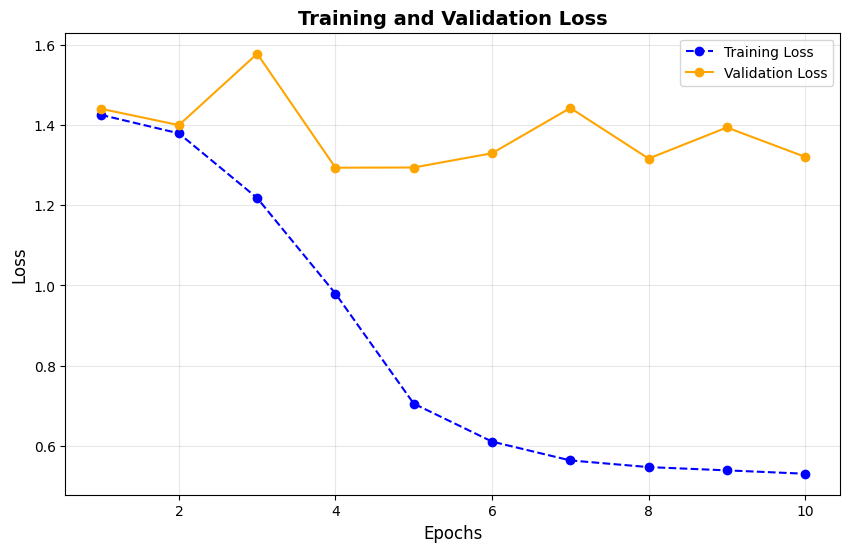

In [16]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker="o", linestyle="--", color="blue")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o", linestyle="-", color="orange")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

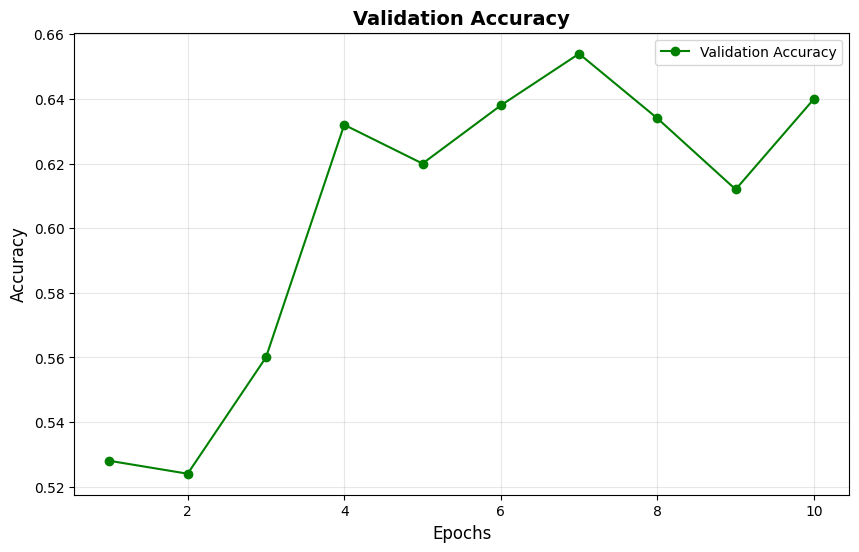

In [17]:
# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o", linestyle="-", color="green")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Validation Accuracy", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

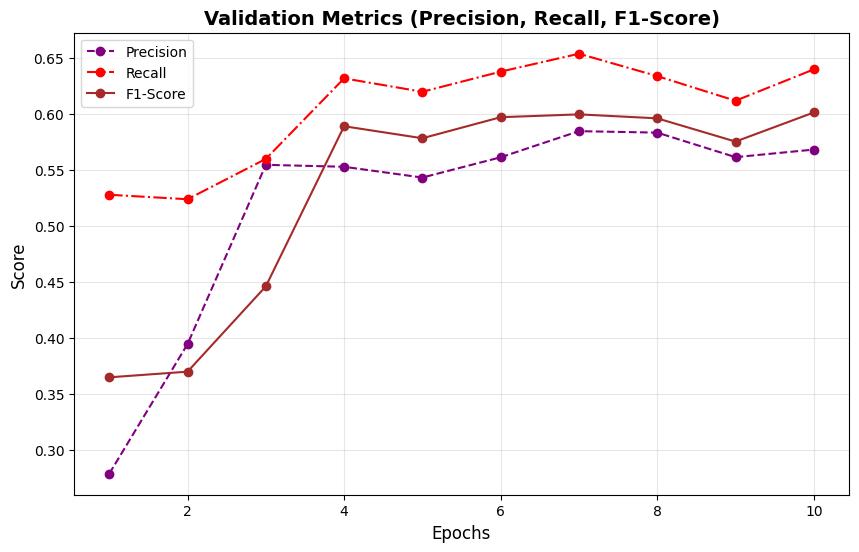

In [18]:
# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_precisions, label="Precision", marker="o", linestyle="--", color="purple")
plt.plot(epochs, val_recalls, label="Recall", marker="o", linestyle="-.", color="red")
plt.plot(epochs, val_f1_scores, label="F1-Score", marker="o", linestyle="-", color="brown")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Validation Metrics (Precision, Recall, F1-Score)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()